In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection    import train_test_split, ParameterSampler, RandomizedSearchCV
from sklearn.base               import TransformerMixin, BaseEstimator, clone
from sklearn.ensemble           import *
from sklearn.metrics            import mean_squared_error, make_scorer
from sklearn.pipeline           import Pipeline, make_pipeline
from sklearn.preprocessing      import *
from sklearn.impute             import *
from sklearn.compose            import *
from sklearn.feature_selection  import SelectFromModel
from sklearn.decomposition      import PCA
from sklearn.linear_model       import Lasso, LinearRegression
from sklearn.inspection         import permutation_importance

from xgboost                    import XGBRegressor
from lightgbm                   import LGBMRegressor

from scipy.stats                import spearmanr
from scipy.cluster              import hierarchy

from tqdm import tqdm

# 1. Load data

In [2]:
data = pd.read_csv('concrete_data.csv', index_col=0)
y = data.loc[:, '28-d']
X = data.drop('28-d', axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)

# 2. Randomized search for hyperparameters with multiply algorithms

In [3]:
# prepare algorithms
algorithms = []
algorithms.append(Lasso())
algorithms.append(RandomForestRegressor())
algorithms.append(ExtraTreesRegressor()) 
algorithms.append(XGBRegressor(booster='gbtree', n_jobs=-1, objective='reg:squarederror'))
algorithms.append(LGBMRegressor(boosting_type='gbdt', n_jobs=-1))

# prepare hyperparameters
hyperparameters = []

hyperparameters_lasso = {
                        'regressor__alpha': np.linspace(0.1, 1, 10), # strength of regulation, when alpha = 0, lasso degrade to regular linear regression
                        'regressor__max_iter': [1000, 10000, 100000], # iteration to find the minimum point
                        }
hyperparameters_rf = {
                      'regressor__n_estimators': [50, 70, 100, 150, 200, 300], # due to the bootstrapping, one tree only see a subset of data, thus we need to try multiple trees
                      'regressor__max_depth': [6,9, None], # set the max_depth to prevent the random forest to be too deep to prevent overfitting
                      'regressor__min_samples_leaf': [1,2,3,4,5] # also prevent the random forest goes too specific and prevent over-fitting
                     }       
hyperparameters_etr = {
                      # ExtraTreesRegressor is a modfied version of random forest. Instead of bootstrapping, it uses all data and randomly select one split
                      'regressor__n_estimators': [50, 70, 100, 150, 200, 300],
                      'regressor__max_depth': [6,9, None],
                      'regressor__min_samples_leaf': [1,2,3,4,5],
                      }
hyperparameters_xgb = {
                      'regressor__n_estimators': [50, 70, 100, 150, 200, 300],
                      'regressor__learning_rate': np.logspace(-2, 0, 10),
                      'regressor__max_depth': np.arange(1, 5, 1),
                      }
hyperparameters_lgbm = {
                       'regressor__n_estimators': [50, 70, 100, 150, 200, 300],
                       'regressor__learning_rate': np.logspace(-2, 0, 10),
                       'regressor__max_depth': np.arange(1, 5, 1),
                      }

hyperparameters.append(hyperparameters_lasso)
hyperparameters.append(hyperparameters_rf)
hyperparameters.append(hyperparameters_etr)
hyperparameters.append(hyperparameters_xgb)
hyperparameters.append(hyperparameters_lgbm)


In [4]:
def rand_cv(algorithms, hyperparameters, X, y):
    """
    walk through all algorithms
    random search the potential hyperparameters for each algorithm
    return list of rmse score lists with total 20 hyperparameter combinations for all algorithms and model objects
    """
    best_score_rmse = []
    all_models = []

    for i, algorithm in enumerate(tqdm(algorithms)):
        pipe = Pipeline([('scaler', StandardScaler()), ('regressor', algorithm)])

        regressor_rand_cv = RandomizedSearchCV(estimator=pipe, 
                                            param_distributions=hyperparameters[i], 
                                            n_iter=20, 
                                            cv=5, 
                                            n_jobs=-1,
                                            verbose=False,
                                            scoring='neg_root_mean_squared_error',
                                        )
        
        regressor_rand_cv.fit(X, y)
        all_models.append(regressor_rand_cv)

        best_score_rmse.append(regressor_rand_cv.cv_results_['mean_test_score'])

    return best_score_rmse, all_models

def compare_models(best_score_rmse_concat, model_names):
    """
    plots and compare rmse scores for all algorithms
    """
    fig, ax = plt.subplots(1, figsize=(9,6))
    ax.boxplot(-best_score_rmse_concat)
    ax.set_ylabel('RMSE')
    ax.set_xticklabels(model_names)
    plt.show()

In [5]:
best_score_rmse, all_models = rand_cv(algorithms, hyperparameters, X_train, y_train)

100%|██████████| 5/5 [01:03<00:00, 12.66s/it]


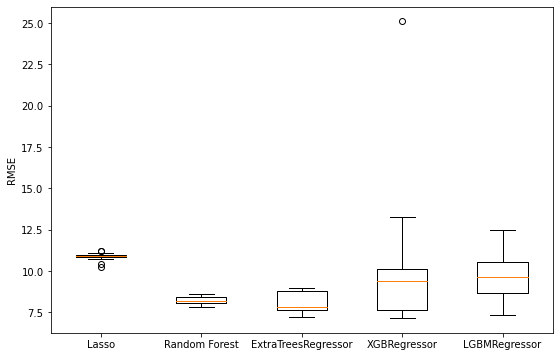

In [6]:
compare_models(np.array(best_score_rmse).T, ['Lasso', 'Random Forest', 'ExtraTreesRegressor', 'XGBRegressor', 'LGBMRegressor'])

In [7]:
best_model = all_models[2].best_estimator_

# 3. Compare predicted target with true target

In [57]:
def plot_pred_vs_true(y_pred, y_test):
    fig, ax = plt.subplots(1, figsize=(7,6))
    ax.scatter(y_pred, y_test)
    ax.axline([0, 0], [1, 1], ls='--')
    ax.set_xlabel('Predicted strength (MPa)')
    ax.set_ylabel('True strength (MPa)')
    plt.show()

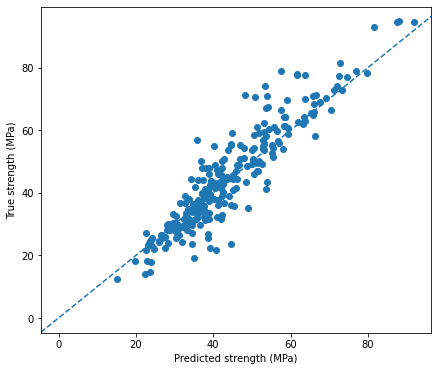

In [58]:
y_pred = best_model.predict(X_test)

plot_pred_vs_true(y_pred, y_test)

In [10]:
print(f"RMSE is {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")

RMSE is 6.55


# 4. Feature importance
## 4.1. Permutation importance

In [11]:
def permutation_importance_plot(best_model, X_train, y_train, figsize):
    result = permutation_importance(best_model, X_train, y_train, random_state=42)
    sorted_idx = result.importances_mean.argsort()

    fig, ax = plt.subplots(figsize=figsize) #(7,30)
    ax.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=X_train.columns[sorted_idx])
    ax.set_title("Feature Importances")
    plt.show()

    return result, sorted_idx

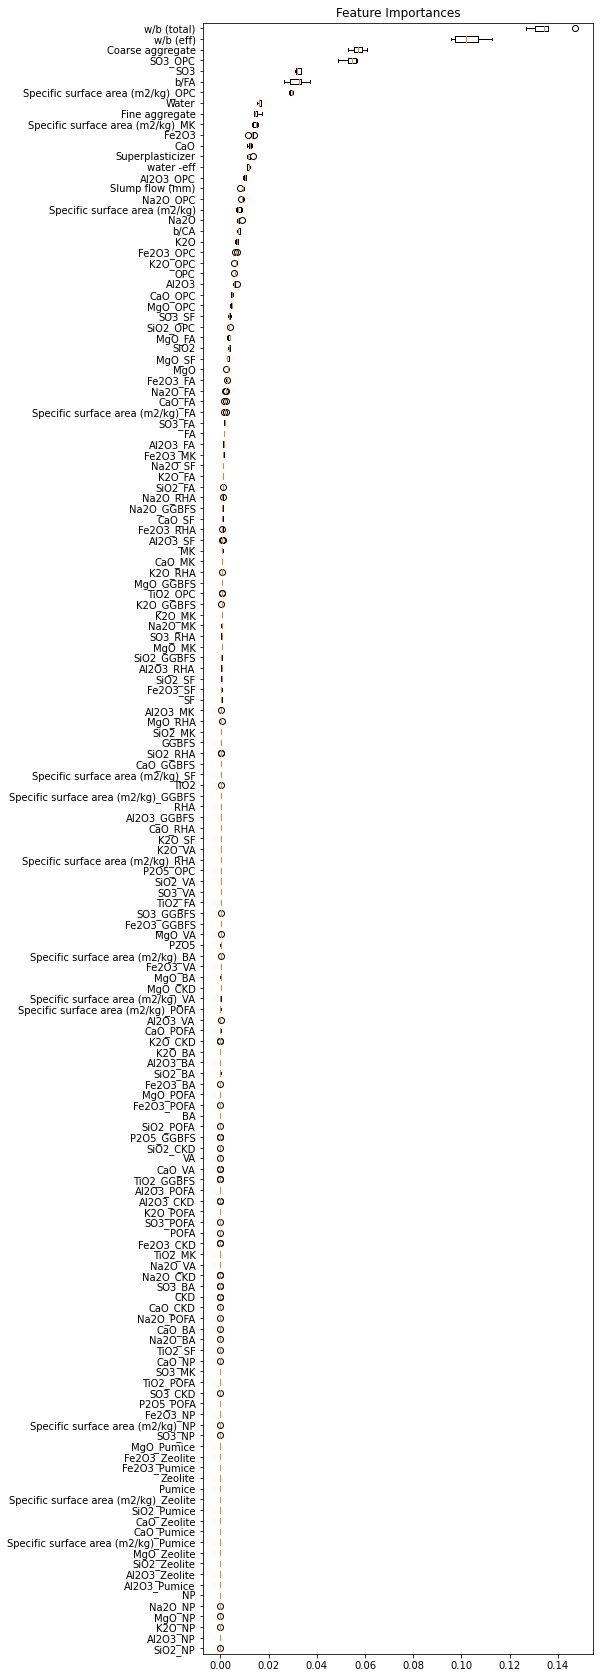

In [12]:
result, sorted_idx = permutation_importance_plot(best_model, X_train, y_train, (7,30))

## 4.2. Handling multicollinear features
### 4.2.1. Identify multicollinear features

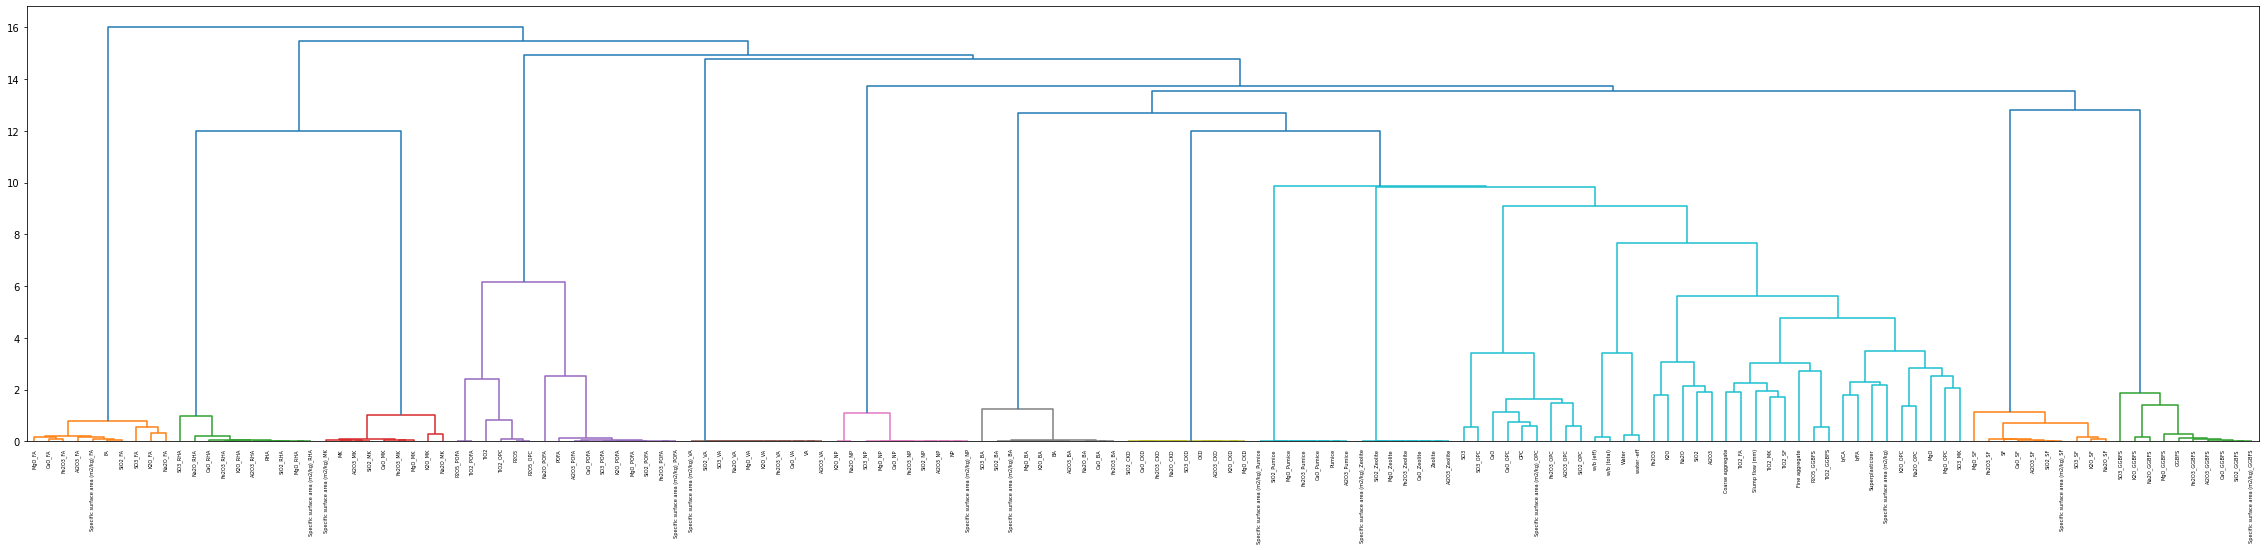

In [13]:
fig, ax = plt.subplots(figsize=(40, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(
    corr_linkage, labels=X_train.columns.tolist(), ax=ax, leaf_rotation=90
)
dendro_idx = np.arange(0, len(dendro['ivl']))
ax.set_label(s=5)
plt.show()

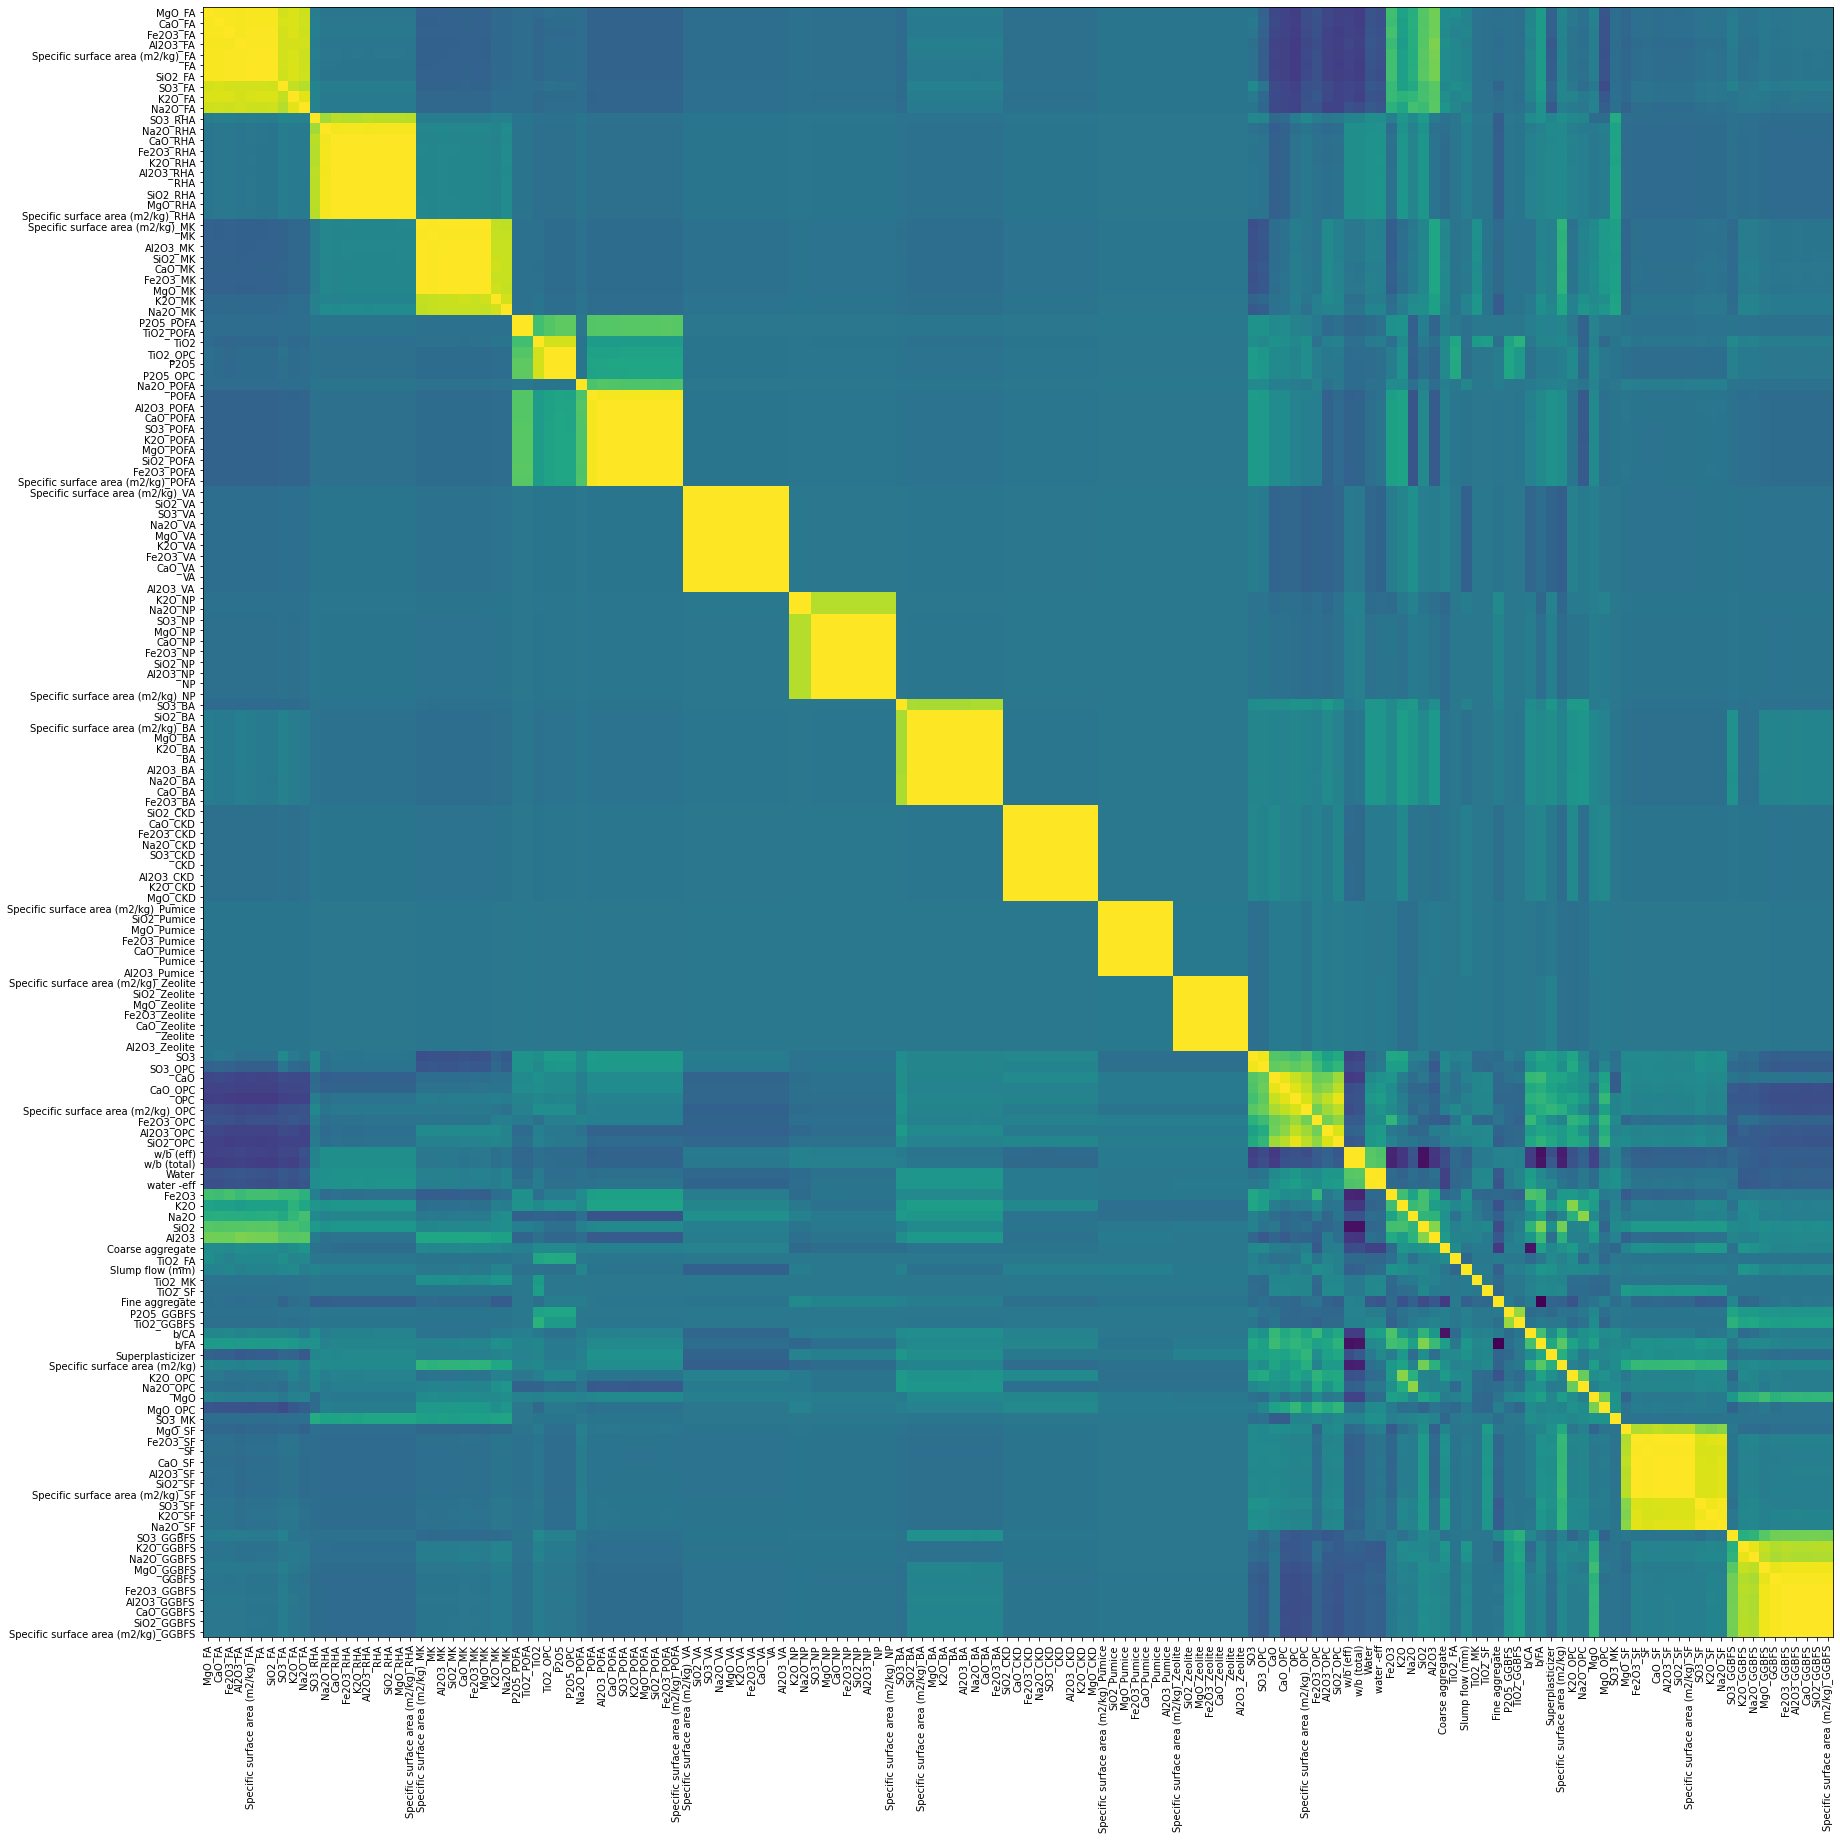

In [14]:
fig, ax = plt.subplots(figsize=(30, 30))
ax.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax.set_xticks(dendro_idx)
ax.set_yticks(dendro_idx)
ax.set_xticklabels(dendro['ivl'], rotation='vertical')
ax.set_yticklabels(dendro['ivl'])
plt.show()

### 4.2.2. Keep a single feature from each cluster

In [15]:
from collections import defaultdict

cluster_ids = hierarchy.fcluster(corr_linkage, 1, criterion='distance')
cluster_id_to_feature_ids = defaultdict(list)
for idx, cluster_id in enumerate(cluster_ids):
    cluster_id_to_feature_ids[cluster_id].append(idx)
selected_features = [v[0] for v in cluster_id_to_feature_ids.values()]

In [16]:
X_train_multicollinear_sel = X_train.iloc[:, selected_features]
X_test_multicollinear_sel = X_test.iloc[:, selected_features]

In [17]:
print(f'The number of features decrease from {len(X_train.columns)} to {len(X_train_multicollinear_sel.columns)}')

The number of features decrease from 153 to 48


# 5. Redo hyperparameters search for data with selected features

In [18]:
best_score_rmse_multicollinear_sel, all_models_multicollinear_sel = rand_cv(algorithms, hyperparameters, X_train_multicollinear_sel, y_train)

100%|██████████| 5/5 [01:15<00:00, 15.18s/it]


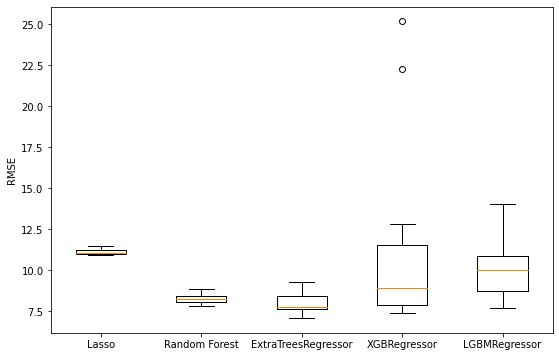

In [19]:
compare_models(np.array(best_score_rmse_multicollinear_sel).T, ['Lasso', 'Random Forest', 'ExtraTreesRegressor', 'XGBRegressor', 'LGBMRegressor'])

In [20]:
best_model_multicollinear_sel = all_models_multicollinear_sel[2].best_estimator_

# 6. Redo prediction for data with selected features

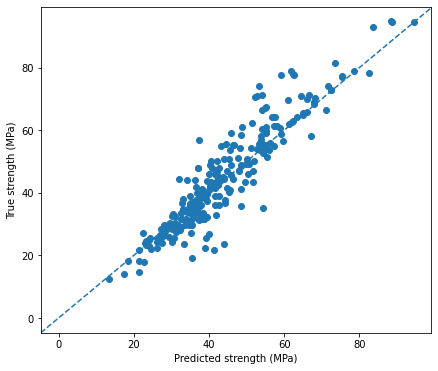

In [60]:
y_pred_multicollinear_sel = best_model_multicollinear_sel.predict(X_test_multicollinear_sel)

plot_pred_vs_true(y_pred_multicollinear_sel, y_test)

In [22]:
print(f"RMSE is {np.sqrt(mean_squared_error(y_test, y_pred_multicollinear_sel)):.2f}")

RMSE is 6.31


# 7. Redo feature importance for data with selected features

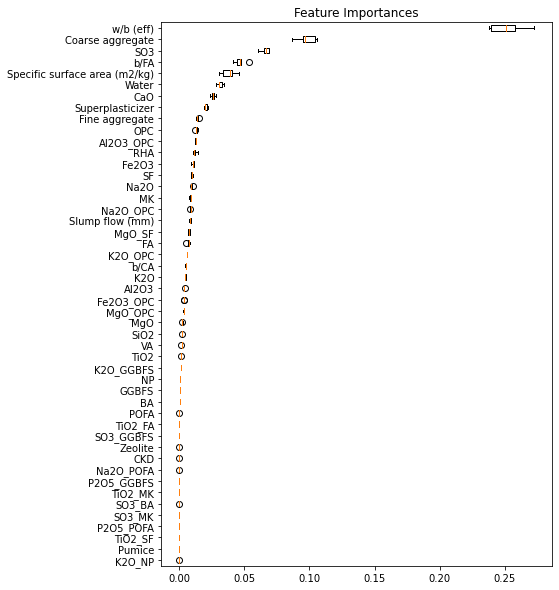

In [23]:
result_multicollinear_sel, sorted_idx_multicollinear_sel = permutation_importance_plot(best_model_multicollinear_sel, 
                                                                                       X_train_multicollinear_sel, y_train,
                                                                                       (7,10))

# 8. Empirical p-values for feature importances

In [24]:
nb_runs = 80
results_shuffle = []
for i in tqdm(range(nb_runs)):
    result_shuffle = permutation_importance(best_model_multicollinear_sel, X_train_multicollinear_sel, y_train.sample(frac=1.0), n_repeats=1,
                                    random_state=42)
    results_shuffle.append(result_shuffle['importances'])

results_shuffle = np.concatenate(results_shuffle, axis=1)

100%|██████████| 80/80 [03:11<00:00,  2.39s/it]


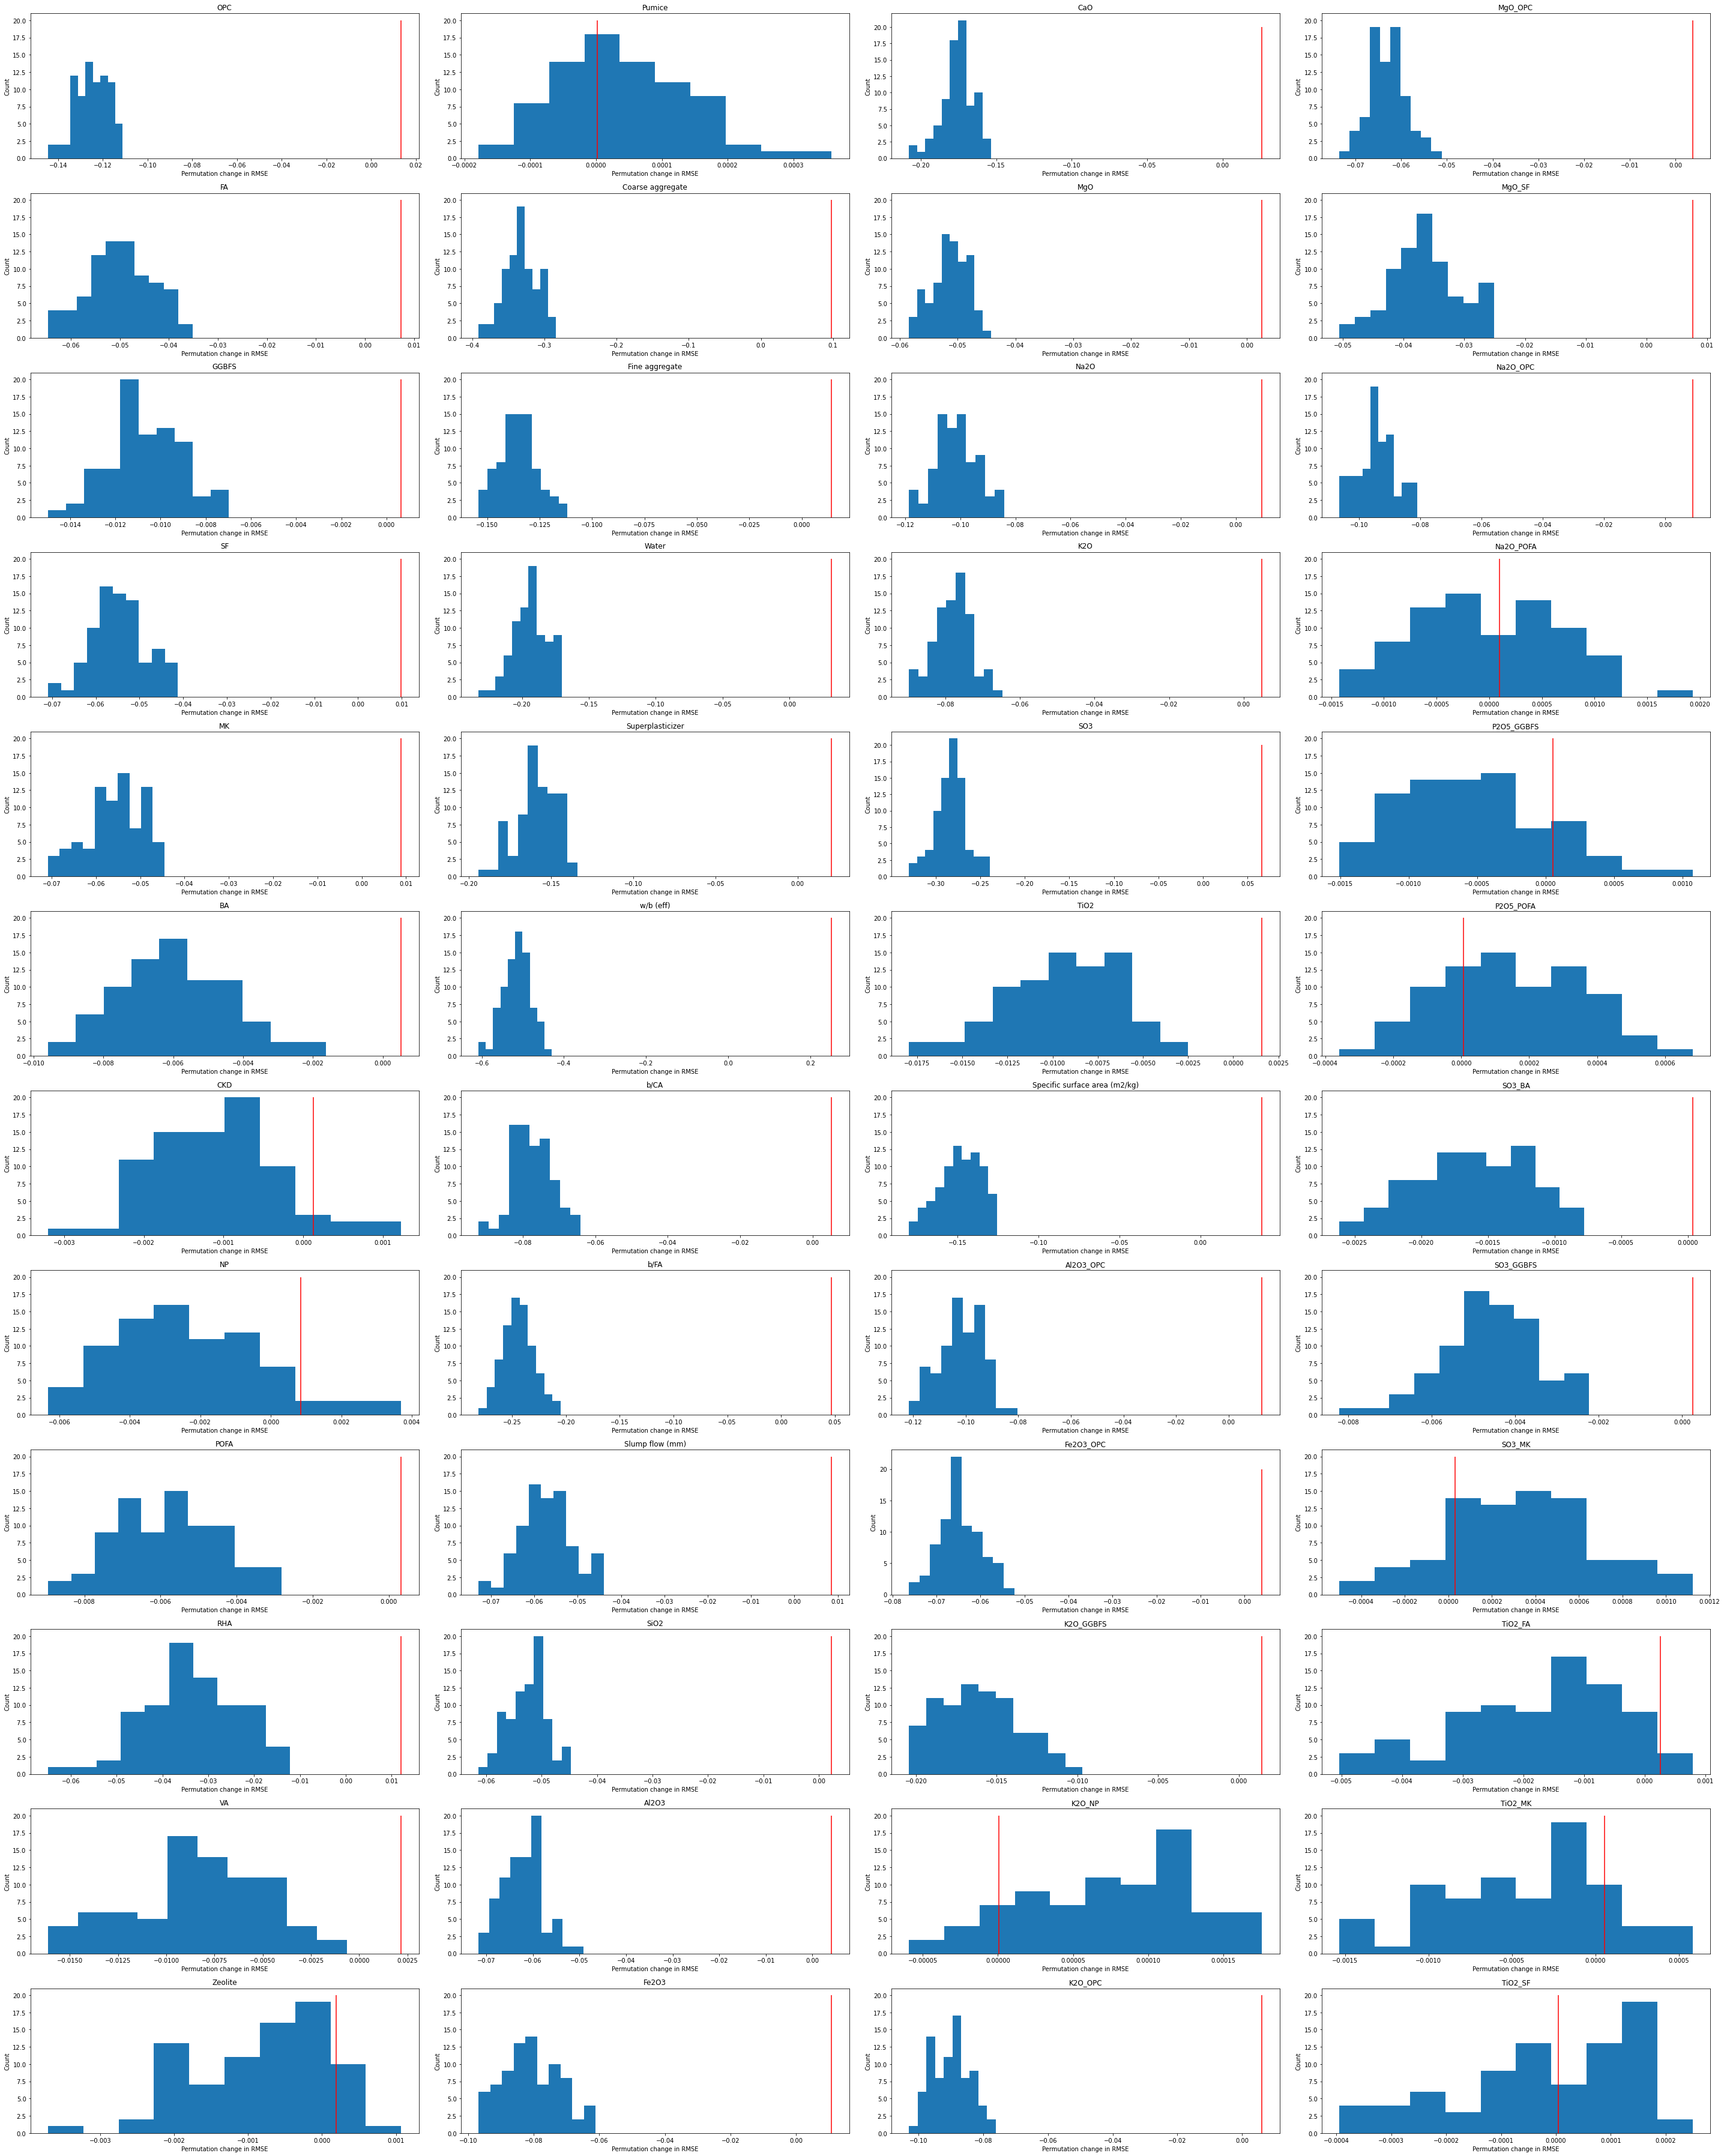

In [25]:
n_features = len(result_multicollinear_sel['importances_mean'])
n_col = 4
n_row = int(n_features/4)

fig, axes = plt.subplots(n_row, n_col, figsize=(40,50))
for i in range(n_features):
    axes[i%n_row][i//n_row].hist(results_shuffle[i])
    axes[i%n_row][i//n_row].vlines(result_multicollinear_sel['importances_mean'][i], 0, 20, color='red')
    axes[i%n_row][i//n_row].set_xlabel('Permutation change in RMSE')
    axes[i%n_row][i//n_row].set_ylabel('Count')
    axes[i%n_row][i//n_row].set_title(X_train_multicollinear_sel.columns[i])

plt.tight_layout()
plt.show()


# 9. Filter features according to p-value and domain knowledge

In [26]:
X_train_sel_final = X_train_multicollinear_sel[X_train_multicollinear_sel.columns[sorted_idx_multicollinear_sel][-9:]]
X_test_sel_final = X_test_multicollinear_sel[X_test_multicollinear_sel.columns[sorted_idx_multicollinear_sel][-9:]]

In [27]:
print(f'The number of features decrease from {len(X_train_multicollinear_sel.columns)} to {len(X_train_sel_final.columns)}')

The number of features decrease from 48 to 9


In [28]:
best_score_rmse_final_sel, all_models_final_sel = rand_cv(algorithms, hyperparameters, X_train_sel_final, y_train)

100%|██████████| 5/5 [01:20<00:00, 16.08s/it]


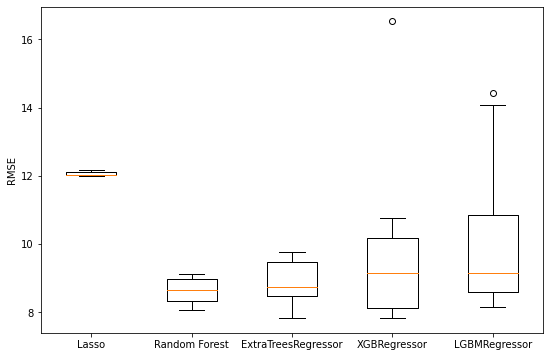

In [29]:
compare_models(np.array(best_score_rmse_final_sel).T, 
               ['Lasso', 'Random Forest', 'ExtraTreesRegressor', 'XGBRegressor', 'LGBMRegressor'])

In [30]:
best_model_final_sel = all_models_final_sel[2].best_estimator_

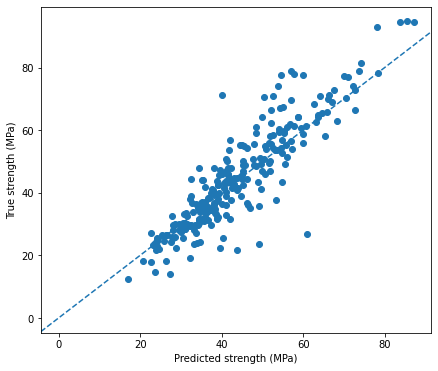

In [59]:
y_pred_final_sel = best_model_final_sel.predict(X_test_sel_final)
plot_pred_vs_true(y_pred_final_sel, y_test)

In [35]:
print(f"RMSE is {np.sqrt(mean_squared_error(y_test, y_pred_final_sel)):.2f}")

RMSE is 7.47


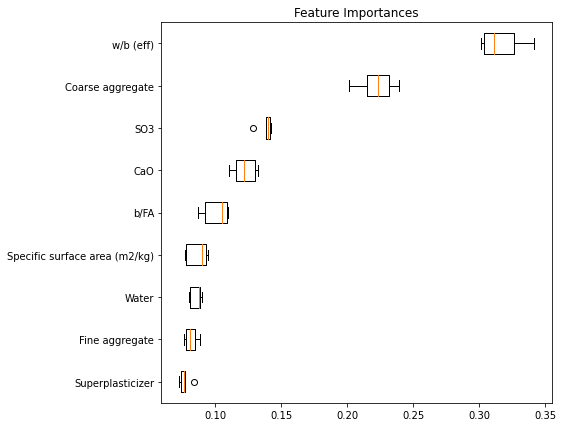

In [36]:
result_final_sel, sorted_idx_final_sel = permutation_importance_plot(best_model_final_sel, 
                                                                                       X_train_sel_final, y_train,
                                                                                       (7,7))

In [37]:
import pickle
filename = 'final_model_sel.sav'
with open(filename, 'wb') as file:
    pickle.dump(best_model_final_sel, file)


In [ ]:
# filename = 'final_model.sav'
# with open(filename, 'rb') as f:
#     best_model_by_randcv = pickle.load(f)